In [1]:
# Standard imports
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
import pandas as pd
import time
import numpy as np
from datetime import datetime, timedelta
import datetime
import sys
import pickle

# Tensorflow imports
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.layers import MaxPooling1D
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras import regularizers
from keras.regularizers import L1L2
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import optimizers
from keras_tuner import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters

# For plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

/tmp/ipykernel_177729/2281816557.py:31: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


In [2]:
#Parameters
name = "error"
n_input = 24

In [ ]:
data_type = "ind_week"
tf.keras.utils.set_random_seed(42)

In [3]:
df = pd.read_csv("/work/Master project/data/data_5_clean_lstm.csv")

df = df
df = df.set_index('date')

num_cols = ['air_temp','humidity','solar_radiation','dew_point_temp']
remainder_cols = ['hour_sin','hour_cos','week_sin','week_cos','month_sin','month_cos','day_of_the_week_sin','day_of_the_week_cos','is_weekend' ]

print("Min Date:", df.index.min())
print("Max Date:", df.index.max())

Min Date: 2021-01-01 00:00:00
Max Date: 2024-01-01 22:00:00


In [4]:
# evaluate performance
def performance(name, score, scores):
 use_scores = ', '.join(['%.1f' % s for s in scores])
 print('%s: [%.3f] %s' % (name, score, use_scores))
    
 # Creating a dictionary of the data
 data = {'Model': [name],
        'Overall RMSE-score': [score]}

 # Dynamically create columns for scores
 data.update({f'RMSE Score {i}': [scores[i-1]] for i in range(1, 25)})

 # Creating a DataFrame from the dictionary
 df = pd.DataFrame(data)
    
 # Appending the new data to the DataFrame
 df.to_csv('LSTM_{}_output.csv'.format(data_type), mode='a', index=False, header=False)
  


In [5]:
#standerdize data
def preprocess(X,mean,std,feature):
    X.iloc[:,feature] = (X.iloc[:,feature] - mean) / std
    return X


In [6]:
df.index = pd.to_datetime(df.index, format='%d/%m/%Y %H:%M')
data1 = df.loc['2021-01-01 00:00:00': '2023-12-31 23:00:00'].copy()
data1.index = pd.to_datetime(data1.index)
data1 = data1.resample("H").sum()

# Choose colomns
data = data1[["electricity_cons",'air_temp', "hour_sin", "hour_cos", 'day_of_the_week_sin','day_of_the_week_cos','is_weekend', 'month_cos', 'month_sin','week_sin','week_cos']]

# Split into train/test sets
def split_data(data):
    # split into whole days
    train_start, train_end = '2021-01-01 12:00:00', '2022-12-31 11:59:00'
    test_start, test_end = '2023-01-01 12:00:00', '2023-12-31 11:59:00'
    
    train = data.loc[train_start:train_end]
    test = data.loc[test_start:test_end]

     # standerdize data

    cons_train_mean = np.mean(train.iloc[:,0])
    cons_train_std = np.std(train.iloc[:,0])
    train = preprocess(train,cons_train_mean,cons_train_std,0)
    test = preprocess(test,cons_train_mean,cons_train_std,0)

    air_train_mean = np.mean(train.iloc[:,1])
    air_train_std = np.std(train.iloc[:,1])
    train = preprocess(train,air_train_mean,air_train_std,1)
    test = preprocess(test,air_train_mean,air_train_std,1)

    # hum_train_mean = np.mean(train.iloc[:,2])
    # hum_train_std = np.std(train.iloc[:,2])
    # train = preprocess(train,hum_train_mean,hum_train_std,2)
    # test = preprocess(test,hum_train_mean,hum_train_std,2)

    # rad_train_mean = np.mean(train.iloc[:,3])
    # rad_train_std = np.std(train.iloc[:,3])
    # train = preprocess(train,rad_train_mean,rad_train_std,3)
    # test = preprocess(test,rad_train_mean,rad_train_std,3)

    # temp_train_mean = np.mean(train.iloc[:,4])
    # temp_train_std = np.std(train.iloc[:,4])
    # train = preprocess(train,temp_train_mean,temp_train_std,4)
    # test = preprocess(test,temp_train_mean,temp_train_std,4)
   
    
    
    # restructure into windows of daily data
    train = array(split(train.values, len(train)/24))
    test = array(split(test.values, len(test)/24))

    return train, test, cons_train_mean, cons_train_std,  air_train_mean,  air_train_std

In [7]:
# evaluate one or more daily forecasts against expected values
def evaluate_forecast(actual, predicted):
    scores = list()
    
	# calculate an RMSE score for each hour
    for i in range(actual.shape[1]):
		# calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
        rmse = sqrt(mse)
		# store (changede to mse since it otherwise would not make sense on the plot)
        scores.append(rmse)
    
	# calculate overall RMSE
    sum = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            sum += (actual[row, col] - predicted[row, col])**2
    score = sqrt(sum / (actual.shape[0] * actual.shape[1]))
    
    # calculate error distribution
    error_dist = np.zeros_like(actual, dtype=float)
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            squared_error = (actual[row, col] - predicted[row, col])**2
            error_dist[row, col] = sqrt(squared_error)
    return score, scores, error_dist

In [8]:
# convert history into inputs and outputs
def to_x_y(train, n_input, n_out=24):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_start = in_end + 12
        out_end = out_start + n_out

        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[out_start:out_end, 0])

        # move along one time step
        in_start += 1

    return array(X), array(y)


In [9]:
class LSTM_model(HyperModel):
    
    def __init__(self, n_input, n_features):
        self.n_input = n_input
        self.n_features = n_features

    def build(self, hp):
     # define model
     model = tf.keras.Sequential()
     activation = hp.Choice('activation', values=['relu', 'tanh'])
     learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
     model.add(tf.keras.layers.Conv1D(filters = hp.Choice('conv_filters', values=[2, 4, 8, 16, 32, 64, 128, 256, 512]),
                      kernel_size = hp.Choice('kernel_size', values=[1, 3, 5, 7]),
                      activation=activation, 
                      input_shape=(self.n_input, self.n_features)))
        
     model.add(MaxPooling1D(pool_size = hp.Choice('pool_size', values=[2, 4, 6])))

   #  model.add(Flatten())
               
     model.add(LSTM(hp.Choice('layer_2_neurons', values=[2, 4, 8, 16, 32, 64, 128, 256, 512]),input_shape=(self.n_input, self.n_features)))
               
     model.add(Dropout(hp.Float('Dropout_rate', min_value=0, max_value=0.5,step=0.1)))
               
     model.add(tf.keras.layers.Dense(24))
               
     model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
     return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [8, 16, 32, 64]),
            **kwargs,
        )


In [10]:
def tuner(train, n_input):

 # prepare data
 train_x, train_y = to_x_y(train, n_input)
    
 n_features = train_x.shape[2]
    
 hypermodel = LSTM_model(n_input, n_features)   

 tuner = kt.Hyperband(hypermodel,
                     objective = 'val_loss',
                     max_epochs = 25,
                     factor = 3,
                     directory = 'tuners/LSTM_CNN_{}'.format(data_type),
                     project_name = 'test')

 stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, mode="min")

 tuner.search(train_x, train_y, epochs = 50, validation_split = 0.2, callbacks=[stop_early])

 # [0] because it return a list of the best to the worst
 best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
 print(best_hps)
 model = tuner.hypermodel.build(best_hps)
 print(model)
 history = model.fit(train_x, train_y, epochs = 50, validation_split = 0.2, callbacks=[stop_early])

 #save model
 model.save('Models/{}.keras'.format(name))

 with open('hp/{}_hyperparameters.pkl'.format(name), 'wb') as f:
     pickle.dump(best_hps.values, f)   
  
 return model, history

In [11]:
# make a forecast for the next day
def forecaster(model, his_data, n_input):
    
	# flatten data
	data = array(his_data)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
	# retrieve last observations for input data
	input_x = data[-n_input:, :]
    
	# reshape into [1, n_input, n]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    
	# forecast the next day
	forecast = model.predict(input_x, verbose=0)
    
	# we only want the vector forecast
	forecast = forecast[0]
	return forecast

In [12]:
# evaluate a single model
def evaluate_model(train, test, n_input, mean_cons, std_cons, mean_air, std_air, data):
    
 # fit model
 model, history_epoch = tuner(train, n_input)
    
 # his_data is a list of real data
 his_data = [x for x in train]
    
 # walk-forward validation over each day
 predictions = list()

 start, end = '2022-12-31 12:00:00', '2023-01-01 11:59:00'
 add_data = data.loc[start:end].copy()
 add_data.iloc[:,0] = (add_data.iloc[:,0]-mean_cons)/std_cons
 add_data.iloc[:,1] = (add_data.iloc[:,1]-mean_air)/std_air
 add_data = array(split(add_data.values, len(add_data)/24)) 
 add_data = add_data[0]
 his_data.append(add_data)
  
 for i in range(len(test)):
	# predict the next day
    forecast = forecaster(model, his_data, n_input)
	# store the forecast
    predictions.append(forecast)
	# get real data and add to his_data for predicting the next day
    his_data.append(test[i,:])

    # if (i + 1) % 7 == 0:
    #      train = array(his_data)
    #      train_x, train_y = to_x_y(train, n_input)
    #      # Retrain the model with the updated training data
    #      model.fit(train_x, train_y, epochs = 1)
    
 # re_transform
 predictions = array(predictions)
 predictions = (predictions*std_cons)+mean_cons
 start, end = '2023-01-02 00:00:00', '2023-12-31 23:00:00'
 actuals = data1.loc[start:end].copy()
 #actuals =  (actuals*std)+mean   
 actuals = array(split(actuals.values, len(actuals)/24))
 actuals = actuals[:, :, 0]


 # evaluate forecasts 
 score, scores, error_dist = evaluate_forecast(actuals, predictions)
    
 return score, scores, predictions, actuals, error_dist, history_epoch, model

In [13]:
# run the prediction

# splitting into train and test data
train, test, mean_cons, std_cons, mean_air, std_air = split_data(data)

# evaluating the model and getting the scores
score, scores, predictions, actuals, error_dist, history, model = evaluate_model(train, test, n_input, mean_cons, std_cons, mean_air, std_air, data)

print(model.summary())


df_error_dist = pd.DataFrame(error_dist)

df_error_dist.to_csv('error_dist/{}_error_dist.csv'.format(name) , index=False)


# summarize scores
performance(name, score, scores)

Trial 30 Complete [00h 18m 30s]
val_loss: 0.5227513909339905

Best val_loss So Far: 0.25943976640701294
Total elapsed time: 02h 08m 44s
<Sequential name=sequential_1, built=True>
Epoch 1/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - loss: 0.7668 - val_loss: 0.3656
Epoch 2/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.3756 - val_loss: 0.3326
Epoch 3/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.3387 - val_loss: 0.3222
Epoch 4/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.3173 - val_loss: 0.3234
Epoch 5/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.3008 - val_loss: 0.3137
Epoch 6/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.2887 - val_loss: 0.3015
Epoch 7/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.2801 - val_loss: 0.3068
Epoch 8/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - loss: 0.2728 - val_loss: 0.2953
Epoch 9/50
437/437 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - loss: 0.2666 - val_loss: 0.2923
Epoch 10/50
437/437 ━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 12, 8)          │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 12, 256)        │       271,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,067,114 (4.07 MB)

 Trainable params: 355,704 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 711,410 (2.71 MB)

None
Best_model_12: [32.273] 35.7, 33.9, 35.4, 37.5, 39.8, 37.7, 31.0, 31.0, 32.9, 35.3, 37.4, 44.0, 30.0, 29.4, 25.9, 26.9, 26.4, 30.2, 26.1, 29.8, 29.2, 26.1, 26.3, 27.9


In [7]:
# Print history loss
print(history.history['loss'])
plt.plot(history.history['loss'], label='Training Loss',color="red")
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.legend()

ax = plt.subplot(111)

# set the basic lables
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Model Loss')

# tweak the title
ttl = ax.title
ttl.set_weight('bold')

# tweak the axis labels
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(10)
ylab.set_style('italic')
ylab.set_size(10)

# grid on
ax.grid('on', linestyle = "--", alpha=0.5)

# color of plot, just to be sure
ax.set_facecolor('xkcd:white')

# change the color of the top and right spines to opaque gray
ax.spines['right'].set_color((.8,.8,.8))
ax.spines['top'].set_color((.8,.8,.8))


plt.savefig('epochs/{}.png'.format(name))
plt.show()


NameError: name 'history' is not defined

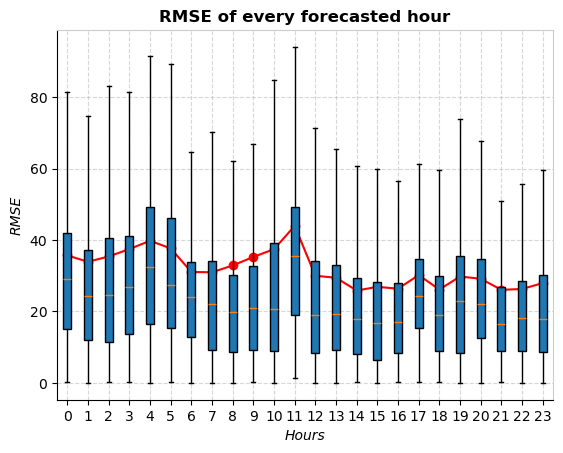

In [15]:
# plot scores

hours = ['00', '01', '02', '03', '04', '05', '06','07', '08', '09', '10', '11', '12', '13','14', '15', '16', '17', '18', '19', '20','21', '22', '23']
plt.figure(figsize=(9, 5))

boxplot_positions = np.arange(len(hours))
# Add boxplots for each column in the error_dist array
for col in range(error_dist.shape[1]):
    boxplot_values = error_dist[:, col]
    plt.boxplot(boxplot_values, positions=[col], widths=0.4, showfliers=False, patch_artist=True, medianprops=dict(color='black'))


plt.plot(hours, scores, marker='o', label='lstm', color="red")
ax = plt.subplot(111)

# set the basic lables
ax.set_xlabel('Hours')
ax.set_ylabel('RMSE')
ax.set_title('Average hourly RMSE')

# tweak the title
ttl = ax.title
ttl.set_weight('bold')

# tweak the axis labels
xlab = ax.xaxis.get_label()
ylab = ax.yaxis.get_label()
xlab.set_style('italic')
xlab.set_size(10)
ylab.set_style('italic')
ylab.set_size(10)

# grid on
ax.grid('on', linestyle = "--", alpha=0.5)

# color of plot, just to be sure
ax.set_facecolor('xkcd:white')

# change the color of the top and right spines to opaque gray
ax.spines['right'].set_color((.8,.8,.8))
ax.spines['top'].set_color((.8,.8,.8))


plt.savefig('scores/{}.png'.format(name))
plt.show()


In [17]:
pio.renderers.default='browser'
pio.templates.default = "seaborn"
plt.style.use('seaborn-v0_8-darkgrid')

predictions = predictions.flatten()
actuals = actuals.flatten()
result = pd.DataFrame({'preds': predictions, 'actuals': actuals})

start_date = '2023-01-02 00:00:00'
end_date = '2023-12-31 23:59:00'
date_format = '%Y-%m-%d %H:%M:%S'


# Create datetime index
datetime_index = pd.date_range(start=start_date, end=end_date, freq='H')

# Create DataFrame with datetime index, predictions, and actuals
resultss = pd.DataFrame({'Datetime': datetime_index, 'Preds': predictions, 'Actuals': actuals})

# Save DataFrame to CSV file
resultss.to_csv('predictions/{}_predictions_actuals.csv'.format(name), index=False)


start_datetime = datetime.datetime.strptime(start_date, date_format)
end_datetime = datetime.datetime.strptime(end_date, date_format)

date_range = pd.date_range(start=start_datetime, end=end_datetime, freq='H')

result = result.set_index(date_range)

fig = go.Figure([
    go.Scatter(
        name='Prediction',
        x=result.index,
        y=result["preds"],
        mode='lines',
    ),
    go.Scatter(
        name='Real value',
        x=result.index,
        y=result["actuals"],
        mode='lines',
     )
])


fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Demand",
    plot_bgcolor='white',
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.1,
        xanchor="left",
        x=0.001
    ),
    xaxis=dict(linecolor='black',showgrid=True, gridcolor='rgba(0, 0, 0, 0.3)',griddash='dash',mirror=True),
    yaxis=dict(linecolor='black',showgrid=True, gridcolor='rgba(0, 0, 0, 0.3)',griddash='dash',mirror=True),
)



fig.write_html('predictions/{}.html'.format(name), auto_open=True)
fig.show()

